In [1]:
import numpy as np
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import os
from torchvision import datasets, transforms
from torch.optim import Adam

from pytorch_lightning import Trainer, seed_everything

import utils as utils

DATA_DIR = './fashionMNIST/'

In [2]:
class LitMNIST(LightningModule):

    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Conv2d(1, 32, 3)
        self.layer_2 = torch.nn.MaxPool2d(2)
        self.layer_3 = torch.nn.Conv2d(32, 64, 3)
        self.layer_4 = torch.nn.MaxPool2d(2)
        self.layer_5 = torch.nn.Conv2d(64, 64, 3)
        self.fc1 = torch.nn.Linear(64 * 3 * 3, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        # x = x.view(batch_size, -1)
        
        # conv + relu
        x = self.layer_1(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_2(x)
        
        # conv + relu
        x = self.layer_3(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_4(x)
        
        # conv + relu
        x = self.layer_5(x)
        x = torch.relu(x)

        # flatten
        x = torch.flatten(x, start_dim=1)
        
        # densely connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        
        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def prepare_data(self):
        # transforms for images
        transform=transforms.Compose([transforms.ToTensor()])
        fmnist_train = FashionMNIST(DATA_DIR, train=True, download=True, transform=transform)
        self.fmnist_test = FashionMNIST(DATA_DIR, train=False, download=True, transform=transform)
        
        self.fmnist_train, self.fmnist_val = random_split(fmnist_train, [55000, 5000])
        
    def train_dataloader(self):
        return DataLoader(self.fmnist_train, batch_size=64, num_workers=utils.get_num_cpus())

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=64, num_workers=utils.get_num_cpus())

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=64, num_workers=utils.get_num_cpus())

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        
        return {'test_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': tensorboard_logs}

In [3]:
net = LitMNIST()
x = torch.Tensor(1, 1, 28, 28)
out = net(x)

In [4]:
out

tensor([[-4.3609e+33, -3.3449e+33, -1.5454e+33, -3.4646e+33, -5.5621e+33,
         -5.3164e+33, -4.1833e+33, -5.3613e+33,  0.0000e+00, -9.2463e+33]],
       grad_fn=<LogSoftmaxBackward>)

In [5]:
net.prepare_data()

In [6]:
# Class map from the fashion mnist website https://github.com/zalandoresearch/fashion-mnist
classes = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle Boot'}

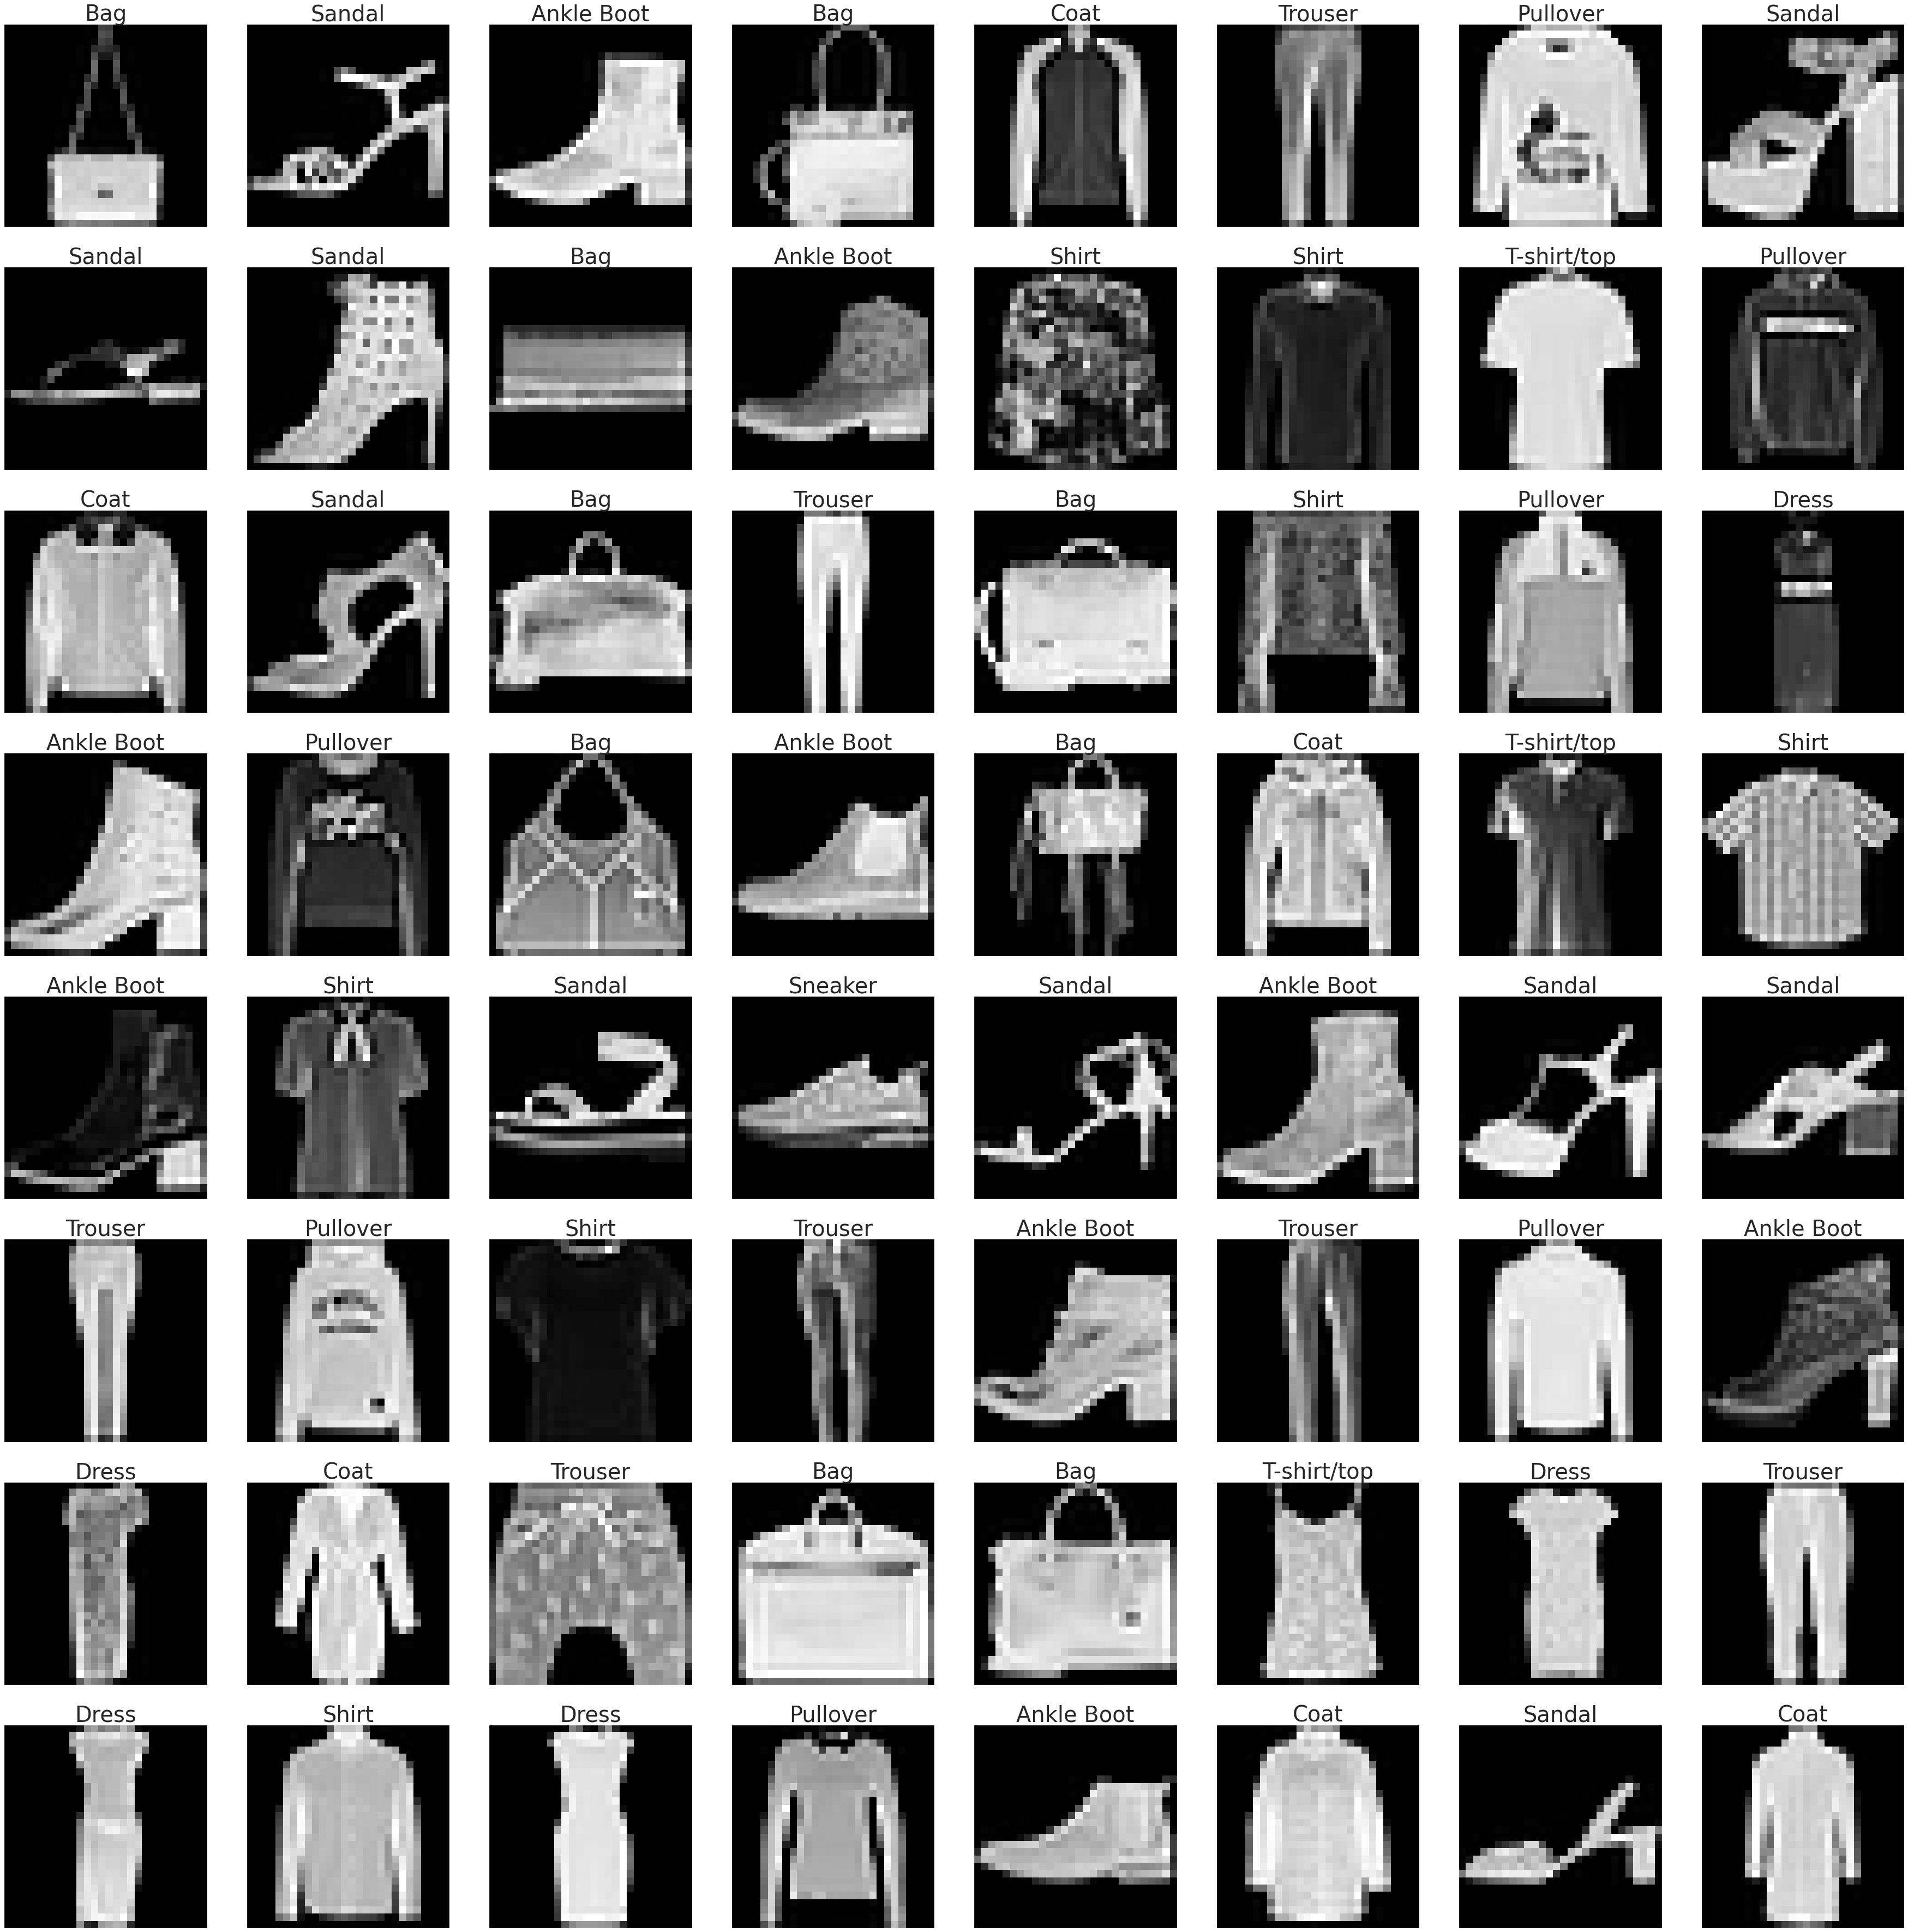

In [7]:
dl = net.train_dataloader()
utils.display_grid_data(dl, classes, ncols=8)

In [8]:
# Setup lightning for reproducability between runs.  That way we can
# make tweaks and see what the effect on performance is.  If we don't set this we will
# get different accuracy results between runs, and will complicate measuring the effect
# of our changes on the performance.  We also have to setup the trainer for deterministic
# runs as well (below)

seed_val = 42
seed_everything(seed_val)

42

In [9]:
model = LitMNIST()
# Set the trainer for deterministic runs.
trainer = Trainer(max_epochs=10, deterministic=True)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type      | Params
--------------------------------------
0 | layer_1 | Conv2d    | 320   
1 | layer_2 | MaxPool2d | 0     
2 | layer_3 | Conv2d    | 18 K  
3 | layer_4 | MaxPool2d | 0     
4 | layer_5 | Conv2d    | 36 K  
5 | fc1     | Linear    | 36 K  
6 | fc2     | Linear    | 650   


1

In [10]:
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.2997)}
--------------------------------------------------------------------------------



{'test_loss': 0.2996547222137451}

In [11]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 27150), started 0:21:31 ago. (Use '!kill 27150' to kill it.)

In [12]:
dl = model.test_dataloader()
import utils as utils

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


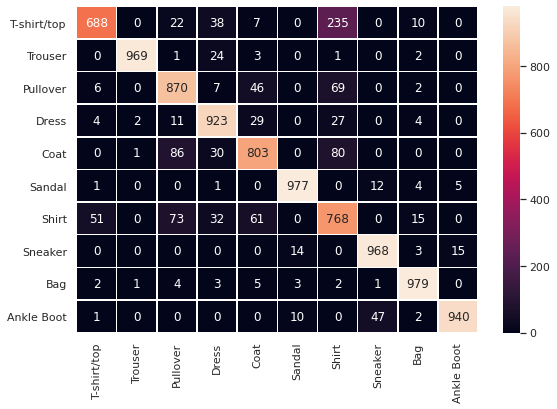

In [31]:
labels, predictions = utils.model_predictions(dl, model)
df, acc = utils.measure_accuracy(labels, predictions, classes)

In [32]:
df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle Boot
T-shirt/top,688,0,22,38,7,0,235,0,10,0
Trouser,0,969,1,24,3,0,1,0,2,0
Pullover,6,0,870,7,46,0,69,0,2,0
Dress,4,2,11,923,29,0,27,0,4,0
Coat,0,1,86,30,803,0,80,0,0,0
Sandal,1,0,0,1,0,977,0,12,4,5
Shirt,51,0,73,32,61,0,768,0,15,0
Sneaker,0,0,0,0,0,14,0,968,3,15
Bag,2,1,4,3,5,3,2,1,979,0
Ankle Boot,1,0,0,0,0,10,0,47,2,940


In [33]:
acc

0.8885